In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output
import scipy.io
import os

## Load Files:

In [4]:
#Get the list of all files in the specified folder, and shuffle them to generalize:
folder = np.array(os.listdir('CoPhe_Lab/1st_May'))
folder = folder[np.random.permutation(len(folder))]
folder_name = "Cophe_Lab\\1st_May\\" 

#Specify number of files to process:
file_num = 1000
print("Files in folder = ", file_num)
_ = input("Press Enter to continue")

#Load the first matlab file:
file = scipy.io.loadmat(folder_name + folder[0])

#Initialize the array for the XA and YA positions
all_Xpos = np.array(file['XA'])
all_Ypos = np.array(file['YA'])

#Get the Velocities along X-direction for current file:
VXA = file['VXA']

#Extract the first timestep, the initial velocity, and divide it by its magnitude to get the direction (1 or -1)
Y = (VXA[:, 0]/abs(VXA[0, 0]))

#Transform the 1 and -1 to a binary group corresponding to 1=>1 and -1=>0
Y = ((Y + 1)/2).astype('int').reshape(all_Xpos.shape[0], 1)
#Duplicate the 0 and 1 labels across the entire time axis:
all_Y = np.tile(Y, all_Xpos.shape[1])

#Initialize counter to count number of files processed:
processed = 1

for i in range(1, file_num):
    
    #Constant folder name:
    folder_name = "Cophe_Lab\\1st_May\\"  
    
    #Get the MATLAB file, and follow similar steps as above:
    file = scipy.io.loadmat(folder_name + folder[i])
    X_position = np.array(file['XA'])
    Y_position = np.array(file['YA'])
    VXA = file['VXA']
    Y = (VXA[:, 0]/abs(VXA[0, 0]))
    Y = ((Y + 1)/2).astype('int').reshape(X_position.shape[0], 1)
    Y = np.tile(Y, X_position.shape[1])
    all_Xpos = np.concatenate((all_Xpos, X_position), axis = 1)
    all_Ypos = np.concatenate((all_Ypos, Y_position), axis = 1)
    all_Y = np.concatenate((all_Y, Y), axis = 1)
    processed += 1
    print("Files read = ", processed)
    clear_output(wait=True)
    

    

Files read =  1000


Right moving group is 1<br>
Left moving group is 0

#### Function to shuffle the order of the particles so that the each particle does not remain in the same index during each training step. This is to prevent the model constraining the particle's group to that specific index, we need to prevent this so that the model preserves the inherent properties of the collective 

In [5]:
def generate_shuffle(a, b):
    assert len(a) == len(b)
    order = np.random.permutation(len(a))
    return a[order], b[order]

In [6]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

### Generate the training data, X and Y labels

In [22]:
#Stack X and Y position vectors side by side like (X1, Y1), (X2, Y2) .....
X = np.concatenate(((all_Xpos[:, 0]).reshape((42, 1)), (all_Ypos[:, 0]).reshape((42, 1))), axis = 1)
Y = all_Y[:, 0]
X_train, Y_train = generate_shuffle(X, Y)
X_train = X_train.reshape((1, 84))
Y_train = Y_train.reshape((1, 42))

processed = 0

for time in range(1, all_Xpos.shape[1]//100):
    X = np.concatenate(((all_Xpos[:, time]).reshape((42, 1)), (all_Ypos[:, time]).reshape((42, 1))), axis = 1)
    Y = all_Y[:, time]
    #for i in range(42):
    X_example, Y_example = generate_shuffle(X, Y)
    X_example = X_example.reshape([1, -1])
    Y_example = Y_example.reshape([1, -1])
    X_train = np.concatenate((X_train, X_example), axis = 0)
    Y_train = np.concatenate((Y_train, Y_example), axis = 0)
    processed += 1
    print("Instances processed = ", processed)
    clear_output(wait=True)
        

print(X_train.shape)
print(Y_train.shape)

(10010, 84)
(10010, 42)


In [36]:
print(X_train.shape)
print(Y_train.shape)

(10010, 84)
(10010, 42)


### Custom Loss Function:

In [117]:
def penalize_false_positives(y_true, y_pred):
    positives = tf.math.bincount(y_true)[1]
    negatives = tf.size(y_true) - positives
    pos_weight = (positives + negatives)/(2*positives)
    neg_weight = (positives + negatives)/(2*negatives)
    pos_weight = tf.cast(pos_weight, 'float32')
    neg_weight = tf.cast(neg_weight, 'float32')
    y_t = tf.cast(y_true, 'float32')
    weight_vector = 0.01*pos_weight*(1 - y_t) + neg_weight
    squared_difference = tf.square(y_t - y_pred) * weight_vector
    return tf.reduce_mean(squared_difference, axis = -1)

In [135]:
def cut_small_errors(y_true, y_pred):
    y_t = tf.cast(y_true, 'float32')
    not_differentiable_error = tf.abs(y_pred - y_t)*10
    differentiable_error = 
    return tf.reduce_sum(error)

# Model Definition:

In [106]:
#layer_nodes = [20, 50, 80, 50, 42]
layer_nodes = [800, 2000, 3200, 2000, 42]
dropout_probs = [0, 0.1, 0.2, 0.1, 0]

#Activations:
sigmoid = tf.keras.activations.sigmoid
relu = tf.keras.activations.relu

activations = [relu, relu, relu, relu, sigmoid]
inputs = tf.keras.layers.Input(shape = (84,))
layer_output = tf.keras.layers.Dense(units = layer_nodes[0], activation = 'relu')(inputs)
layer_output = tf.keras.layers.Dropout(dropout_probs[0])(layer_output)
layer_output = tf.keras.layers.BatchNormalization()(layer_output)

for i in range(1, len(layer_nodes)-1):
    layer_output = tf.keras.layers.Dense(units = layer_nodes[i], activation = activations[i])(layer_output)
    layer_output = tf.keras.layers.Dropout(dropout_probs[i])(layer_output)
    layer_output = tf.keras.layers.BatchNormalization()(layer_output)
    
layer_output = tf.keras.layers.Dense(units = layer_nodes[-1], activation = activations[-1])(layer_output)
    


In [107]:
model = tf.keras.Model(inputs = inputs, outputs = layer_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 84)]              0         
                                                                 
 dense_5 (Dense)             (None, 800)               68000     
                                                                 
 dropout_4 (Dropout)         (None, 800)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 2000)              1602000   
                                                                 
 dropout_5 (Dropout)         (None, 2000)              0         
                                                           

In [136]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3), 
              loss = cut_small_errors,
             metrics = [tf.keras.metrics.Precision()])

In [137]:
history = model.fit(x = X_train, y = Y_train, batch_size = X_train.shape[0], epochs = 500)

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 0.0366 - precision_9: 0.9966
Epoch 2/500
1/1 [==============================] - 3s 3s/step - loss: 0.0439 - precision_9: 0.9960
Epoch 3/500
1/1 [==============================] - 3s 3s/step - loss: 0.0376 - precision_9: 0.9966
Epoch 4/500
1/1 [==============================] - 3s 3s/step - loss: 0.0410 - precision_9: 0.9966
Epoch 5/500
1/1 [==============================] - 3s 3s/step - loss: 0.0394 - precision_9: 0.9965
Epoch 6/500
1/1 [==============================] - 3s 3s/step - loss: 0.0387 - precision_9: 0.9965
Epoch 7/500
1/1 [==============================] - 3s 3s/step - loss: 0.0380 - precision_9: 0.9965
Epoch 8/500
1/1 [==============================] - 3s 3s/step - loss: 0.0379 - precision_9: 0.9965
Epoch 9/500
1/1 [==============================] - 3s 3s/step - loss: 0.0377 - precision_9: 0.9965
Epoch 10/500
1/1 [==============================] - 3s 3s/step - loss: 0.0372 - precision_9: 0.9966
Epoch 11/

1/1 [==============================] - 3s 3s/step - loss: 0.0351 - precision_9: 0.9967
Epoch 84/500
1/1 [==============================] - 3s 3s/step - loss: 0.0350 - precision_9: 0.9967
Epoch 85/500
1/1 [==============================] - 3s 3s/step - loss: 0.0351 - precision_9: 0.9967
Epoch 86/500
1/1 [==============================] - 3s 3s/step - loss: 0.0350 - precision_9: 0.9967
Epoch 87/500
1/1 [==============================] - 3s 3s/step - loss: 0.0349 - precision_9: 0.9967
Epoch 88/500
1/1 [==============================] - 3s 3s/step - loss: 0.0351 - precision_9: 0.9967
Epoch 89/500
1/1 [==============================] - 3s 3s/step - loss: 0.0350 - precision_9: 0.9967
Epoch 90/500
1/1 [==============================] - 3s 3s/step - loss: 0.0350 - precision_9: 0.9967
Epoch 91/500
1/1 [==============================] - 3s 3s/step - loss: 0.0350 - precision_9: 0.9967
Epoch 92/500
1/1 [==============================] - 3s 3s/step - loss: 0.0348 - precision_9: 0.9967
Epoch 93/500


KeyboardInterrupt: 

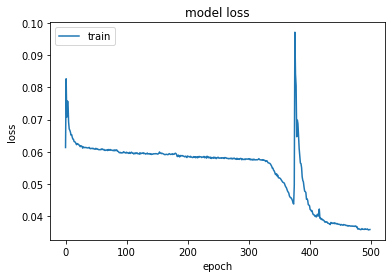

In [138]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
tf.config.run_functions_eagerly(False)

In [121]:
model.save('model_standard.h5')